# 目的

OpenFOAMのicoUncoupledKinematicParcelFoamを使った解析と理論計算を比較する

- $\mu_{f}=1e-05$ : 流体の粘性係数
- $\boldsymbol{u}_{f}$：流体の速度
- $\boldsymbol{v}_{d}$：粒子の速度
- $d_{p}=10$[mm] $=0.01$[k]
- $\rho_{d} = 964$[kg/m3] : 粒子の密度
- $Re_{p}=\frac{|\boldsymbol{u}_{f}-\boldsymbol{v}_{d}|d_{p}}{\mu_{f}/\rho}$ : レイノルズ数
- $F_{D}=\frac{1}{2}C_{d}\rho_{f}A|\boldsymbol{u}_{f}-\boldsymbol{v}_{d}|^2$：抗力
- $A=\pi\big(\frac{d_{p}}{2}\big)^2$

OpenFOAMのアニメーションはこちら

In [117]:
from IPython.display import Video

Video("./particle_base/ani.ogv")

In [118]:
# 必要なライブラリのインポート
import PyFoam
import os, shutil
from PyFoam.RunDictionary.ParsedParameterFile import ParsedParameterFile
from PyFoam.Execution.BasicRunner import BasicRunner
from PyFoam.Execution.GnuplotRunner import GnuplotRunner
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
from PyFoam.Wrappers.Pandas import PyFoamDataFrame as DataFrame
from pathlib import Path
import numpy as np
import os
# from PyFoam.IPythonHelpers.Case import Case

In [119]:
# 解析結果の座標をファイルを取得
result = Path("./particle_base")
cordinateFile = Path("lagrangian/kinematicCloud/positions")
caseList =[result /c /cordinateFile for c in os.listdir(result) if os.path.isfile(result /c /cordinateFile)]
caseList[:5]

[PosixPath('particle_base/0.02/lagrangian/kinematicCloud/positions'),
 PosixPath('particle_base/0.04/lagrangian/kinematicCloud/positions'),
 PosixPath('particle_base/0.06/lagrangian/kinematicCloud/positions'),
 PosixPath('particle_base/0.08/lagrangian/kinematicCloud/positions'),
 PosixPath('particle_base/0.1/lagrangian/kinematicCloud/positions')]

In [120]:
cordList = []
for case in caseList:
    with open(case, "r") as fileobj:
        cor = fileobj.readlines()[18:][1].split(" ")
    cordList.append(cor)

In [121]:
tList = [float(c) for c in os.listdir(result) if os.path.isfile(result /c/cordinateFile)]
xList = [float(cord[0][1:]) for cord in cordList]
yList = [float(cord[1]) for cord in cordList]
zList = [float(cord[2][:-1]) for cord in cordList]

# y方向の座標 

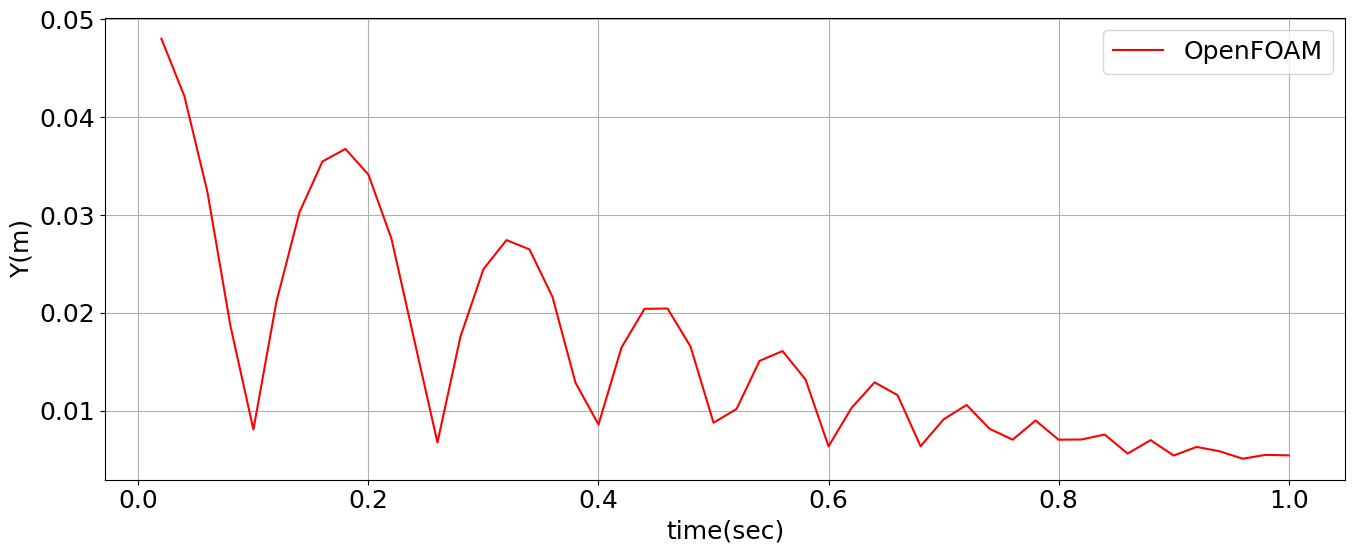

In [122]:
plt.figure(figsize=(16,6))
plt.rcParams["font.size"] = 18
plt.plot(tList, yList, label="OpenFOAM", color="red")
plt.grid()
plt.xlabel("time(sec)")
plt.ylabel("Y(m)")
plt.legend()

# X方向の座標

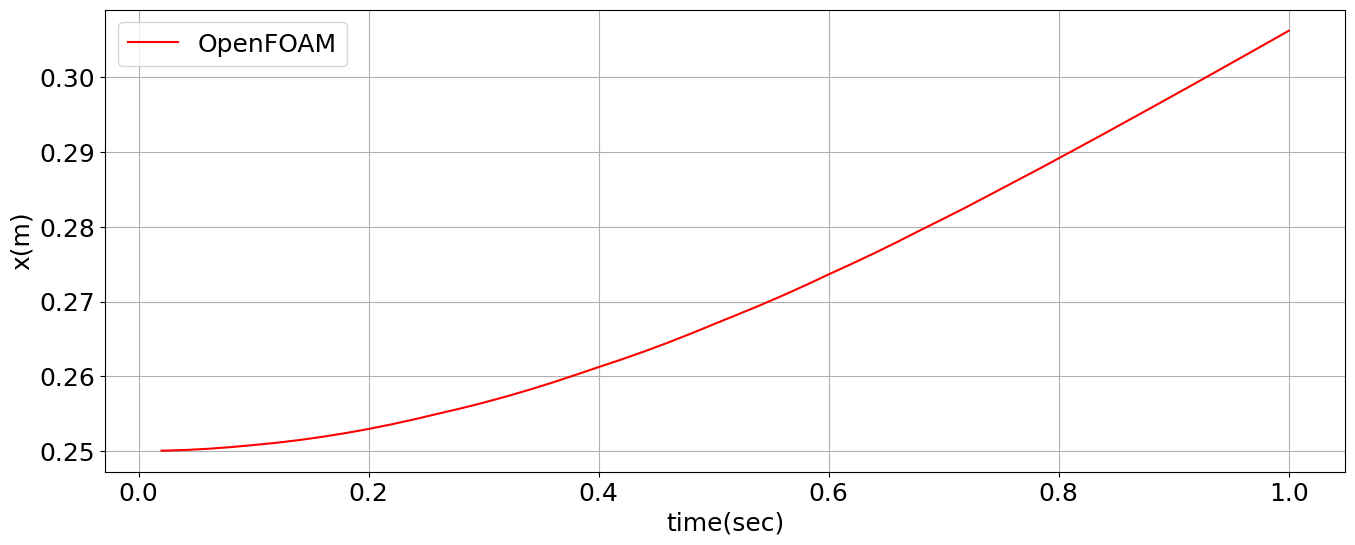

In [123]:
plt.figure(figsize=(16,6))
plt.rcParams["font.size"] = 18
plt.plot(tList, xList, label="OpenFOAM", color="red")
plt.grid()
plt.xlabel("time(sec)")
plt.ylabel("x(m)")
plt.legend()

# 自由落下の式を立てる
- $h=0.05$[m]
- $e=0.83$:反発係数（適当に調整）
- $n$回目のy座標
- $y=0.001$

$$y=-\frac{1}{2}g(t-t_n)^2+e^{n}v_{y}(t-t_n)+h$$

In [124]:
# === 粒子の設定 ====
dp = 0.01         #半径[m]
rhop = 964        #密度[kg/m3]
up = 0.001        #速度[m/s]
# 粒子の質量
mp = 4/3*np.pi*(dp/2)**3*rhop

# === 粒子の設定 ====
rhof = 1.2         #密度
nuf = 1E-5         #動粘性係数

h = 0.05
vy0 = 0

# 重力（浮力も考慮）
g = -9.81*(1-rhof/rhop)

e = 0.83
t = np.arange(0,1.0,0.0001)
y_ = []
ti_ = 0

for ti in t:
    vy_ = g*(ti-ti_)+vy0
    yval = 0.5*g*(ti-ti_)**2 + vy0*(ti-ti_) + h
    if yval<=0.01:
        vy0 = -e*vy_
        ti_ = ti
        h = 0.01


    y_.append(yval)
y = np.array(y_)

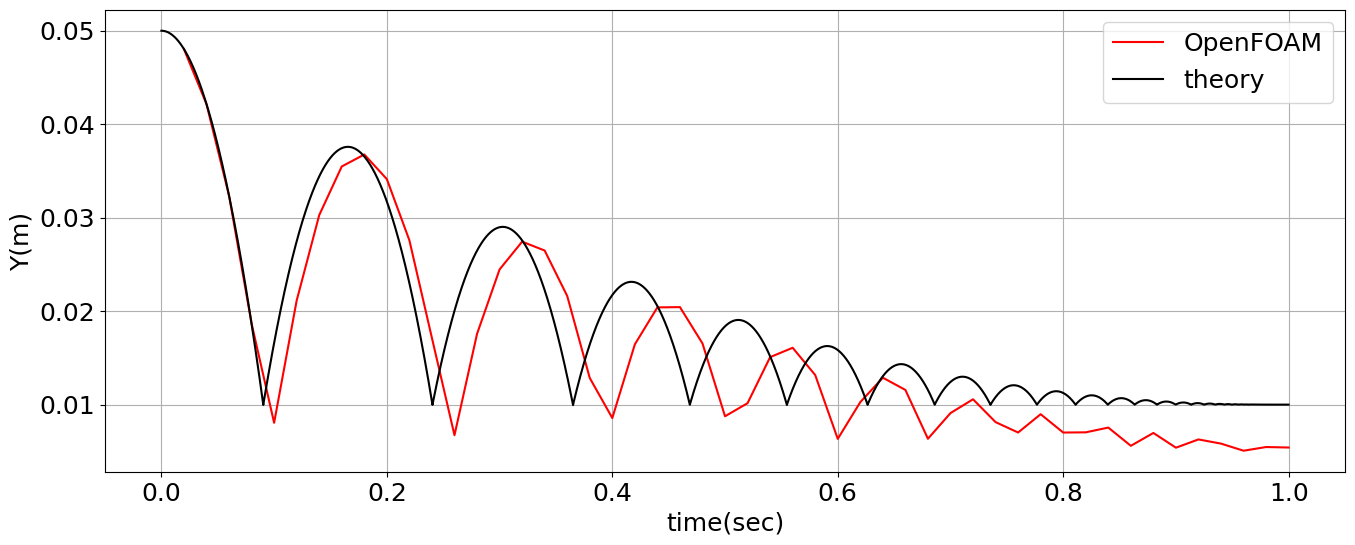

In [125]:
plt.figure(figsize=(16,6))
plt.rcParams["font.size"] = 18
plt.plot(tList, yList, label="OpenFOAM", color="red")
plt.plot(t, y, label="theory", color="black")
plt.grid()
plt.xlabel("time(sec)")
plt.ylabel("Y(m)")
plt.legend()

粒子が壁に接するまでは理論値と一致しています。
粒子のバウンドの理論が異なるので当然合わないがだいたい理解できそう。

## 抗力を考える
- $\mu_{f}=1e-05$ : 流体の粘性係数
- $\boldsymbol{u}_{f}$：流体の速度
- $\boldsymbol{v}_{d}$：粒子の速度
- $d_{p}=10$[mm] $=0.01$[m]
- $\rho_{d} = 964$[kg/m3] : 粒子の密度
- $Re_{p}=\frac{|\boldsymbol{u}-\boldsymbol{v}|d_{p}}{\mu_{f}/\rho}$ : レイノルズ数
- $F_{D}=\frac{1}{2}C_{d}\rho_{f}A|\boldsymbol{u}_{f}-\boldsymbol{v}_{d}|^2=m_{p}\frac{3}{4}\frac{\mu_{f}C_{d}Re_{p}}{\rho_{p}d_{p}^2}|\boldsymbol{u}_{f}-\boldsymbol{v}_{d}|$：抗力
- $A=\pi\big(\frac{d_{p}}{2}\big)^2$

[sourceCode](https://www.openfoam.com/documentation/guides/latest/api/SphereDragForce_8C_source.html#l00049)

[SphereDrag](https://www.openfoam.com/documentation/guides/latest/api/classFoam_1_1SphereDragForce.html)

In [113]:
# === 粒子の設定 ====
dp = 0.01         #半径[m]
rhop = 964        #密度[kg/m3]
up = 0.001        #速度[m/s]
# 粒子の質量
mp = 4/3*np.pi*(dp/2)**3*rhop

# === 流体の設定 ====
rhof = 1.2         #密度
nuf = 1E-5         #動粘性係数
muf = nuf*rhof     #粘性係数
uf = 2.0           #流体の流速

# ===レイノルズ数 ====
Rep = abs(uf - up)*dp/(muf/rhof)

if Rep > 1000.0:
    print("レイノルズ数は1000より大きい")
    Cd = 0.424
    CdRep = Cd*Rep
else:
    print("レイノルズ数は1000以下")
    Cd = 24.0*(1.0 + (1.0/6.0)*Rep**(2.0/3.0))/Rep
    CdRep = Cd*Rep

print(f"レイノルズ数は{round(Rep,4)}")
print(f"抗力係数×レイノルズ数は{CdRep}")

# ==== 抗力の計算 ====
FD = mp*0.75*(muf*CdRep)/(rhop*dp**2)*abs(uf-up)
FD1 = 0.5*Cd*rhof*(dp/2)**2*np.pi*abs(uf-up)**2 #抗力の別の表現
print(f"粒子の質量{mp}kg")
print(f"抗力は{round(FD,5)}N")
print(f"抗力は{round(FD1,5)}N") #抗力の別の表現

レイノルズ数は1000より大きい
レイノルズ数は1999.0
抗力係数×レイノルズ数は847.576
粒子の質量0.0005047492196767602kg
抗力は8e-05N
抗力は8e-05N


$$x = \frac{1}{2}\frac{F_D}{m}t^2+x_{0}$$

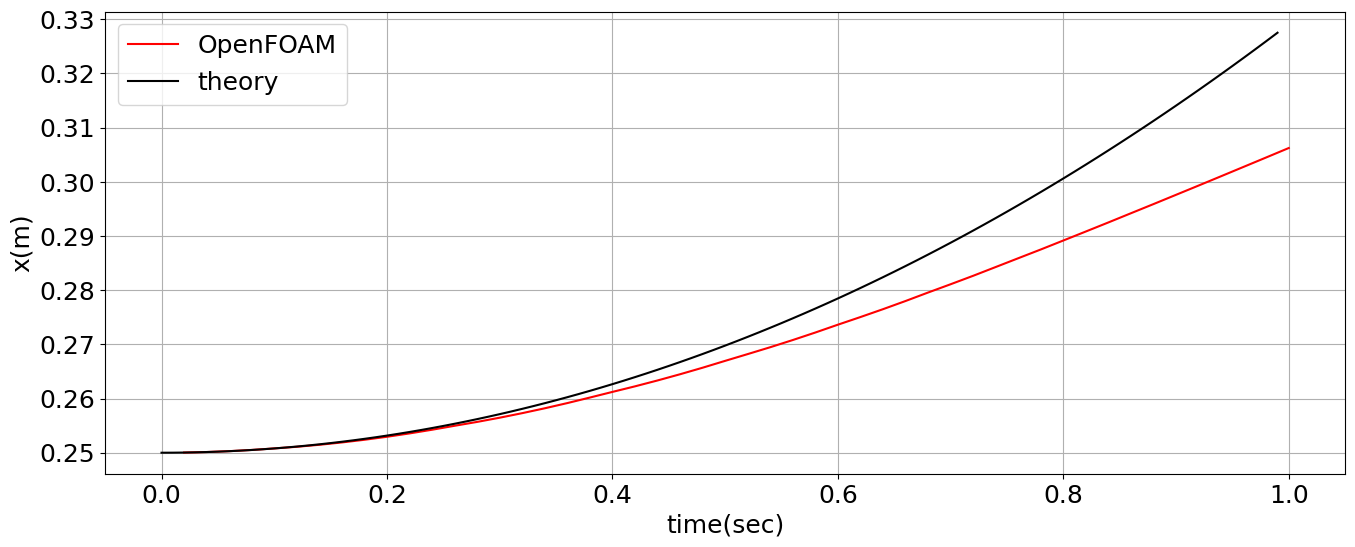

In [126]:
x0 = 0.25
t = np.arange(0,1,0.01)
x = 0.5*(FD1/mp)*t**2 + x0


plt.figure(figsize=(16,6))
plt.rcParams["font.size"] = 18
plt.plot(tList, xList, label="OpenFOAM", color="red")
plt.plot(t, x, label="theory", color="black")
plt.grid()
plt.xlabel("time(sec)")
plt.ylabel("x(m)")
plt.legend()

地面と接するまでは一致していますが、やはり地面と接触して以降は徐々にずれてきます。